# Praca domowa 5

#### Martyna Majchrzak

In [72]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
from scipy.spatial import distance

np.random.seed(1) 

## Dane

In [49]:
# wczytanie danych
data = pd.read_csv('..\\..\\clustering.csv', header=None)
data=data.rename(columns={0: 'x', 1: 'y'})
data.head()

,x,y
0,41.788907,52.220182
1,-96.586516,90.957033
2,-54.143591,-99.153377
3,19.929231,-45.859779
4,-82.941076,84.099186


Dane zawierają dwie zmienne o wartościach numerycznych i 400 obserwacji.

In [50]:
data.describe()

,x,y
count,400.000000,400.000000
mean,-0.580656,-8.010264
std,48.821210,62.096845
min,-107.433649,-128.983720
25%,-34.551495,-70.730416
50%,5.691010,-3.447565
75%,31.456507,45.822610
max,109.733409,99.935839


### Rozkłady zmiennych

{'whiskers': [<matplotlib.lines.Line2D at 0x275bcc82e08>,
 'caps': [<matplotlib.lines.Line2D at 0x275bcc82f88>,
 'boxes': [<matplotlib.lines.Line2D at 0x275bcc825c8>],
 'medians': [<matplotlib.lines.Line2D at 0x275bcc86f88>],
 'fliers': [<matplotlib.lines.Line2D at 0x275bcc8ea88>],
 'means': []}

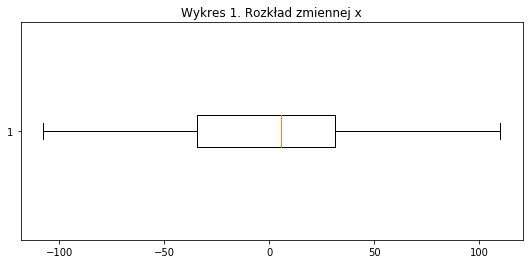

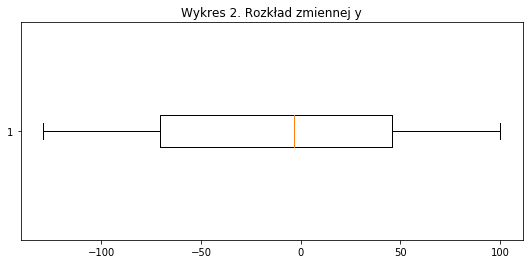

In [51]:
fig, ax = plt.subplots(figsize = (9, 4))
ax.set_title('Wykres 1. Rozkład zmiennej x')
ax.boxplot(data.x, vert=False)

fig, ax = plt.subplots(figsize = (9, 4))
ax.set_title('Wykres 2. Rozkład zmiennej y')
ax.boxplot(data.y, vert=False)

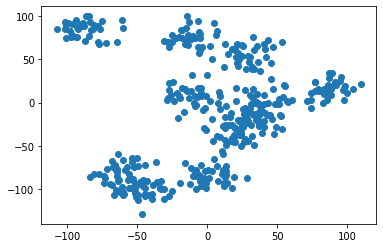

In [52]:
plt.scatter(x=data.x, y=data.y)
plt.show()

## Metoda K-średnich

Najpierw zaprezentujemy przykładowy wykres dla 4 skupień.

In [105]:
from sklearn.cluster import KMeans

X= data.to_numpy()

def plot_kmeans_clusters(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    plt.scatter(X[:,0], X[:,1], c=y_kmeans, s=30, cmap='viridis')

    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
    plt.title('K-means '+str(n_clusters)+' clusters')
    plt.show()

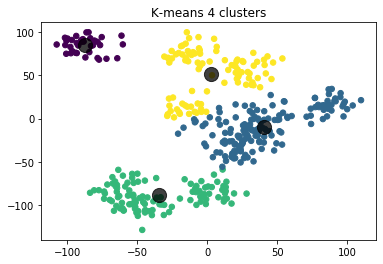

In [106]:
plot_kmeans_clusters(X, n_clusters=4)

Do wybrania odpowiedniej liczby skupisk posłużywmy się metodą 'łokcia', najpierw używając metryki L2.

In [107]:
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

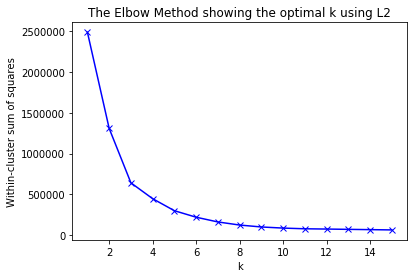

In [108]:
wcss_vec = count_wcss_scores(data, 15)
data_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(data_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k using L2')
plt.show()

Z wykresu dla L2 wynikałowy, że należy wybrać k w okolicach 5-6. 

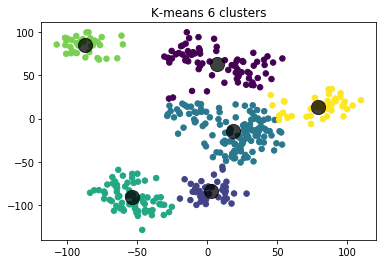

In [117]:
plot_kmeans_clusters(X, n_clusters=6)

Wygląda to nieźle, ale 2 klastry są zdecydowanie większe i bardziej rozrzucone od pozostałych.
Wypróbujemy jeszcze zastosować jako metrykę średnią odległość między punktami w klastrze.
To powinno zapewnić małe odległości wewnątrz klastrów.

In [111]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    # Napiszmy tę funkcje tak ogólnie, jak to możliwe. 
    # Zwróćcie uwagę na przekazanie obiektów typu callable: model i score_fun.
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

In [112]:
def mean_inclust_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)


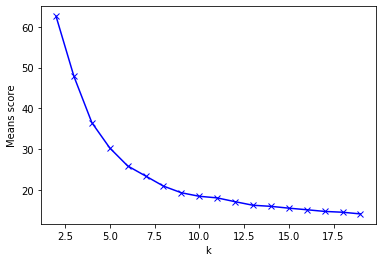

In [115]:
cluster_num_seq = range(2, 20) # Niektóre metryki nie działają gdy mamy tylko jeden klaster
means_vec = count_clustering_scores(X, cluster_num_seq, KMeans, mean_inclust_dists)
plt.plot(cluster_num_seq, means_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Means score')
plt.show()

Ta metryka sugerowałaby wybór nawet wyższej liczby klastrów - w okolicach 7-8.

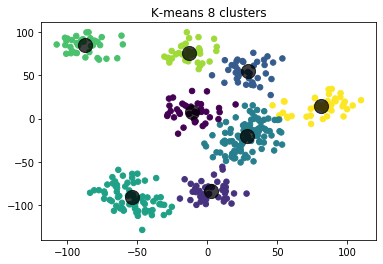

In [154]:
plot_kmeans_clusters(X, n_clusters=8)

Ta ilość wydaje się być optymalna - klastry są dość spójne, ale widać jeszcze pewne niedoskonałości i obserwacje odstające od przypisanych klastrów.

## Metoda Aglomeracyjna

Zaczniemy standardowo od zaprezentowania klasteryzacji dla 4 skupisk z domyślną metodą łączenia.

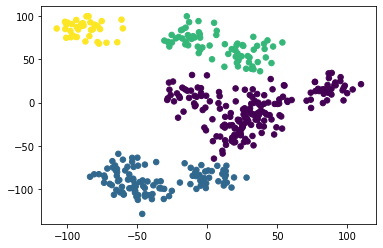

In [122]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=4)
y = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis')
plt.show()

Następnie sprawdzimy 2 metody łączenia klastrów:

    - połączenie średnie
    
    - połączenie Warda
    
W obydwu przypadkach do znalezienia najlepszej liczby klastrów zastosujemy metodę Silhouette.

### Połączenie średnie

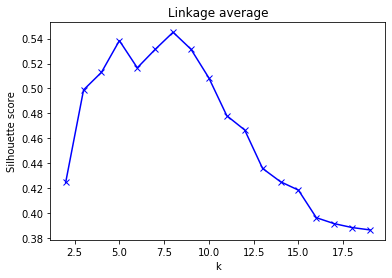

In [164]:
from sklearn.metrics import silhouette_score
from functools import partial
cluster_num_seq = range(2, 20)

means_vec_average = count_clustering_scores(X, cluster_num_seq, partial(AgglomerativeClustering, linkage='average'), silhouette_score)
plt.plot(cluster_num_seq, means_vec_average, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Linkage average')
plt.show()

In [ ]:
Najwięszą wartość miary przyjmowana jest dla k=8.

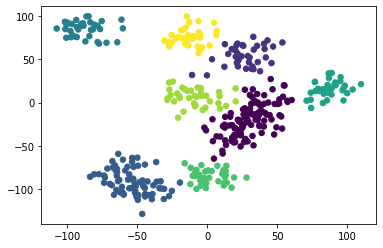

In [146]:
model = AgglomerativeClustering(n_clusters=8, linkage='average')
y = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis')
plt.show()

Wynik wygląda całkiem przyzwoicie, ale w niektórych klastrach widać jeszcze obserwacje mocno 'odstające'.

### Połączenie Warda

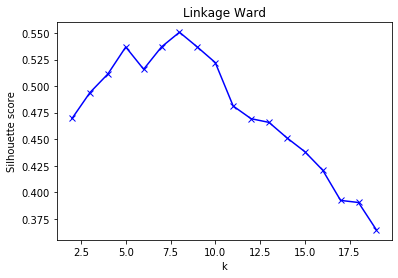

In [166]:
means_vec_ward = count_clustering_scores(X, cluster_num_seq, partial(AgglomerativeClustering, linkage='ward'), silhouette_score)
plt.plot(cluster_num_seq, means_vec_ward, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Linkage Ward')
plt.show()

Ponownie najlepszą liczbą klastrów okazuje się 8.

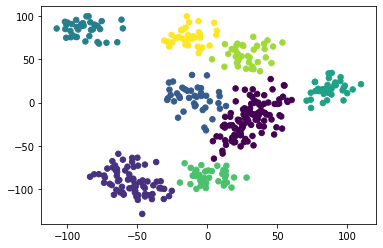

In [152]:
model = AgglomerativeClustering(n_clusters=8, linkage='ward')
y = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis')
plt.show()

Ten ostatni wygląda najlepiej ze wszystkich dotychczas - jest bardzo podobny do wyniku KMeans dla 8 skupisko, ale  np. najbardziej wysunięte na prawo na wykresie skupisko nie zawiera części obserwacji które zaweiera przy klasteryzacji za pomocą KMeans i jest lepiej odseparowany od reszty.

### Połączenie pojedyncze

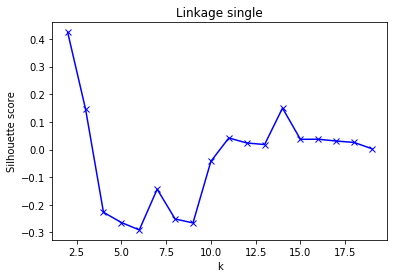

In [168]:
means_vec_single = count_clustering_scores(X, cluster_num_seq, partial(AgglomerativeClustering, linkage='single'), silhouette_score)
plt.plot(cluster_num_seq, means_vec_single, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Linkage single')
plt.show()

Postanowiłam załączyć ten rodzaj klasteryzacji bo daje ciekawe wyniki - niemalże odwrotne od poprzednich. Według tego wykresu dla k w okolicach 8-9 wynik będzie najgorszy, a najlepszy dla k=2 (ale podział na dwa klastry nie wydaje się być zbyt interesujący) i k=14.

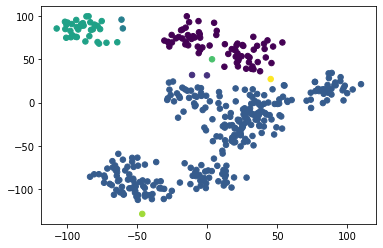

In [159]:
model = AgglomerativeClustering(n_clusters=8, linkage='single')
y = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis')
plt.show()

Rzeczywiście, dla 8 klastrów ta metoda zupełnie się nie sprawdza.

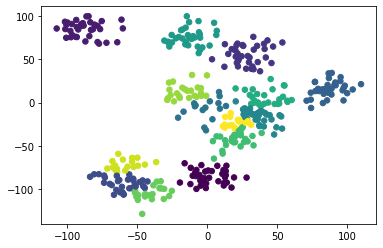

In [163]:
model = AgglomerativeClustering(n_clusters=14, linkage='ward')
y = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis')
plt.show()

Dla 14 klastrów sytuacja wygląda lepiej, ale napewno nie tak jak metoda połączenia średniego lub Warda dla k=8, zresztą wynika to z wykresów Silhouetee score - osiągają tam one ok. 0.55, a metoda połączenia pojedynczego dla k=14 niecałe 0.2. Porównajmy jeszcze dokładnie wyniki Warda i średniej.

In [173]:
means_vec_ward[6]

0.5506938439944646

In [174]:
means_vec_average[6]

0.545134542243861

Zatem najlepszą metodą połączenia przy klasteryzacji aglomeracyjnej będzie metoda połączenia Warda i najlepsze wyniki da dla 8 klastrów.

# Oświadczenie

Oświadczam, że niniejsza praca stanowiąca podstawę do uznania osiągnięcia efektów uczenia się z przedmiotu Wstęp do Uczenia Maszynowego została wykonana przeze mnie samodzielnie.